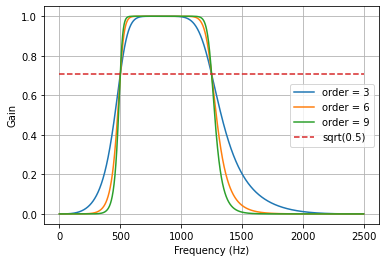

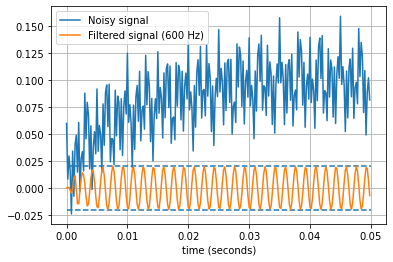

In [1]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, fs=fs, worN=2000)
        plt.plot(w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()

In [2]:
#import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from intake import open_catalog
import cartopy.io.shapereader as shpreader
#import mygrads as mg
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
import math
from sklearn.neighbors import NearestNeighbors

In [3]:
f='/project/xprecip/merra2_ncfiles/slp/anomalies/slp_anoms_traditional_unfiltered_smaller.nc'
DS_slp_anoms=xr.open_dataset(f)
DS_slp_anoms

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 1320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
    hour     (time) int64 ...
Data variables:
    SLP      (time, lat, lon) float32 ...

In [4]:
slp_anoms=DS_slp_anoms['SLP']
slp_anoms

<xarray.DataArray 'SLP' (time: 1320, lat: 66, lon: 120)>
[10454400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
    hour     (time) int64 0 6 12 18 0 6 12 18 0 6 ... 12 18 0 6 12 18 0 6 12 18

In [5]:
slp_sorted=slp_anoms.sortby('time')
slp_sorted

<xarray.DataArray 'SLP' (time: 1320, lat: 66, lon: 120)>
[10454400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
    hour     (time) int64 0 6 12 18 0 6 12 18 0 6 ... 12 18 0 6 12 18 0 6 12 18

In [6]:
slp_nonans=slp_sorted.dropna(dim='time')
slp_nonans

<xarray.DataArray 'SLP' (time: 1320, lat: 66, lon: 120)>
array([[[ -0.267578,  -0.211548, ...,  -1.499268,  -1.487793],
        [ -0.253113,  -0.184265, ...,  -1.481567,  -1.48291 ],
        ...,
        [ -7.689758,  -7.331665, ..., -25.361511, -25.378723],
        [ -6.621948,  -6.632263, ..., -24.341003, -24.314392]],

       [[  0.078674,   0.071167, ...,  -1.894775,  -1.963318],
        [  0.051025,   0.066345, ...,  -1.934937,  -1.982727],
        ...,
        [ -3.827393,  -3.523132, ..., -21.807373, -22.08319 ],
        [ -3.362244,  -3.640503, ..., -21.741577, -22.130249]],

       ...,

       [[ -2.335144,  -2.177673, ...,   0.753235,   0.816589],
        [ -2.788208,  -2.619629, ...,   0.536865,   0.610596],
        ...,
        [ -3.325623,  -2.504089, ...,   1.293274,  -0.167297],
        [ -1.433289,  -1.370239, ...,   1.307129,  -0.240601]],

       [[ -3.681519,  -3.601257, ...,   0.51062 ,   0.539978],
        [ -4.162231,  -4.051331, ...,   0.368591,   0.323792],
        ...,
        [ -4.377441,  -3.737183, ...,   6.585754,   5.705933],
        [ -2.617126,  -2.48761 , ...,   6.336182,   5.448975]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 1983-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
    hour     (time) int64 0 6 12 18 0 6 12 18 0 6 ... 12 18 0 6 12 18 0 6 12 18

In [11]:
import numpy.fft as fft
spectrum = fft.fft(slp_nonans)
spectrum

array([[[ -70.24993896+0.00000000e+00j,  -74.65946857-1.11816694e+02j,
           86.98349287+5.56022613e+01j, ...,
          -12.08222744+6.69342773e+01j,   86.98349287-5.56022613e+01j,
          -74.65946857+1.11816694e+02j],
        [ -75.47509766+0.00000000e+00j,  -74.82445753-1.21535156e+02j,
           90.18233724+6.00172832e+01j, ...,
           -9.36346639+7.05627695e+01j,   90.18233724-6.00172832e+01j,
          -74.82445753+1.21535156e+02j],
        [ -83.78234863+0.00000000e+00j,  -73.32961384-1.32794647e+02j,
           93.69295153+6.48482152e+01j, ...,
           -8.73112841+7.35397031e+01j,   93.69295153-6.48482152e+01j,
          -73.32961384+1.32794647e+02j],
        ...,
        [-663.76757812+0.00000000e+00j, -361.85589102-2.41333864e+02j,
         -153.73233885-1.42213590e+02j, ...,
          -83.13049174+2.08642108e+02j, -153.73233885+1.42213590e+02j,
         -361.85589102+2.41333864e+02j],
        [-656.47692871+0.00000000e+00j, -366.44513974-2.57312137e+02j,
    

In [17]:
nx=len(slp_nonans['lon'])
ny=len(slp_nonans['lat'])
nt=len(slp_nonans['time'])

In [20]:
X=np.reshape(spectrum,((nt,ny*nx)))
X

array([[ -70.24993896  +0.j        ,  -74.65946857-111.81669351j,
          86.98349287 +55.60226125j, ...,  -72.0442396 +199.33188316j,
        -158.35864126+119.59743453j, -365.9017453 +272.33225247j],
       [ -49.7868042   +0.j        ,  -77.22432956-120.3719567j ,
          72.68821658 +54.48458959j, ...,  -57.88259719+196.17334434j,
        -133.30987877 +76.1331993j , -329.41877194+329.8848321j ],
       [ -28.87915039  +0.j        ,  -85.43677245-110.63596475j,
          75.57122693 +62.58425326j, ...,  -38.87759665+216.92404659j,
        -131.46117736 +21.85850197j, -298.44775167+423.94316953j],
       ...,
       [-274.30010986  +0.j        ,   79.35052001 -76.81592362j,
          41.43754979 +40.22079901j, ...,  -12.96320741 -61.65251369j,
         -26.20869931 -35.61121635j, -474.62777846-315.74717576j],
       [-238.07116699  +0.j        ,   55.91967008 -50.08660622j,
          44.60832319 +44.60132547j, ...,   -7.85658425 -86.24160796j,
          -2.92546115 -87.2955428j 

[ 0.          0.00075758  0.00151515 ... -0.00227273 -0.00151515
 -0.00075758]
[<matplotlib.lines.Line2D object at 0x7f3a06a13390>, <matplotlib.lines.Line2D object at 0x7f3a06a13400>, <matplotlib.lines.Line2D object at 0x7f3a06a134a8>, <matplotlib.lines.Line2D object at 0x7f3a06a13550>, <matplotlib.lines.Line2D object at 0x7f3a06a135f8>, <matplotlib.lines.Line2D object at 0x7f3a06a136a0>, <matplotlib.lines.Line2D object at 0x7f3a06a13748>, <matplotlib.lines.Line2D object at 0x7f3a06a137f0>, <matplotlib.lines.Line2D object at 0x7f3a06a13898>, <matplotlib.lines.Line2D object at 0x7f3a06a13940>, <matplotlib.lines.Line2D object at 0x7f3a06a13320>, <matplotlib.lines.Line2D object at 0x7f3a06a13a58>, <matplotlib.lines.Line2D object at 0x7f3a06a13b00>, <matplotlib.lines.Line2D object at 0x7f3a06a13ba8>, <matplotlib.lines.Line2D object at 0x7f3a06a13c50>, <matplotlib.lines.Line2D object at 0x7f3a06a13cf8>, <matplotlib.lines.Line2D object at 0x7f3a06a13da0>, <matplotlib.lines.Line2D object at 0

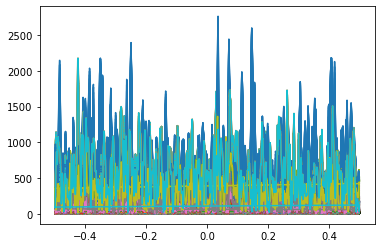

In [26]:
freq = fft.fftfreq(len(X))
print(freq)
print(plt.plot(freq, abs(X)))


In [27]:
print(np.nanmin(freq))
print(np.nanmax(freq))

-0.5
0.49924242424242427


In [8]:
from scipy.signal import firwin

In [9]:
#cutoff = [0.05, 0.7]
numtaps= 66 #we want wavenumbers 5-70?
#length of the filter (number of coefficients, ie. the filter order +1.
#Numtaps must be odd if a passband includes Nyquist frequency)

cutoff=[47.14,660.32] #corresponds to wavenumbers 5-70

#Cutoff frequency of filter (expressed in the same units as fs)
#OR an array of cutoff frequencies (that is, band edges). 
#In the latter case, the frequencies in cutoff should be positive and 
#monotonically increasing between 0 and fs/2. 
#The values 0 and fs/2 must not be included in cutoff.


firwin(numtaps, cutoff, pass_zero='bandpass')


ValueError: Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.